# RSNA EXAMPLE FROM QTIM/Assessing-Saliency-Maps

https://github.com/QTIM-Lab/Assessing-Saliency-Maps

In [1]:
!module load python/3.7
!module load cuda/10.1

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

HOME = '/home-2/jtenegg1@jhu.edu/'

## LOAD PRETRAINED NET

In [5]:
model = models.inception_v3(pretrained=True)
model.aux_logits = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

device = torch.device('cpu')

model.to(device)

net_path = os.path.join(HOME, 'data/Jacopo/HShap/Pretrained_models/PNA/InceptionV3')
model.load_state_dict(torch.load(net_path, map_location=device))

preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.299, 0.224, 0.225])
])

DATA_DIR = os.path.join(HOME, 'data/Jacopo/PNA')
testset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), preprocess)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=4)

In [ ]:
# TEST ACCURACY ON THE WHOLE TEST DATASET
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

print('Accuracy on test set (%d images) = %.2f' % (total, correct/total))

In [14]:
!module load python/3.7
!module load cuda/10.1

from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import os
import copy
import pandas as pd

HOME = '/home-2/jtenegg1@jhu.edu/'

IMG_DIR = os.path.join(HOME, 'data/Jacopo/PNA/test/sick')
EXPLANATION_DIR = os.path.join(HOME, 'data/Jacopo/PNA_sick_explanations')
patients = os.listdir(EXPLANATION_DIR)
PATIENT_L = len(patients)

preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor()
])

annotations_path = os.path.join(HOME, 'data/Jacopo/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
df = pd.read_csv(annotations_path)
df_id = df[['patientId']]
df_x = df[['x']]
df_y = df[['y']]
df_width = df[['width']]
df_height = df[['height']]
id = df_id.values.flatten()
x = df_x.values.flatten()
y = df_y.values.flatten()
width = df_width.values.flatten()
height = df.height.values.flatten()

def imshow(ax, pic):
    npimg = np.array(pic)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

sizes = [40, 20, 10, 5]
thresholds = [0, 0.5, 1.5]
SIZE_L = len(sizes)
THRESH_L = len(thresholds)
EXP_L = SIZE_L * THRESH_L
INPUT_SIZE = 299
for patient_id, patient in enumerate(patients):
    fig = plt.figure(figsize=(11, 15))
    plt.suptitle('Explanation maps for class "sick"\npatient ID: %s' % patient)
    axes = fig.subplots(SIZE_L, THRESH_L)
    pic = Image.open(os.path.join(IMG_DIR, '%s.png' % patient)).convert('RGB')
    pic_w, pic_h = pic.size
    input = preprocess(pic)
    PATIENT_DIR = os.path.join(EXPLANATION_DIR, patient)
    for threshold_id, threshold in enumerate(thresholds):
        for size_id, size in enumerate(sizes):
            explanation = np.load(os.path.join(PATIENT_DIR, '%d_%d.npy' % (threshold_id, size)))
            abs = np.abs(explanation.flatten())
            max = np.percentile(abs, 99.9)
            ax = axes[size_id, threshold_id]
            imshow(ax, input)
            im = ax.imshow(explanation, cmap='bwr', alpha=0.5, vmax=max, vmin=-max)
            # CREATE BOX PATCHES
            annotations = np.where(id == patient)[0]
            for annotation in annotations:
                box_x = x[annotation]
                box_y = y[annotation]
                box_w = width[annotation]
                box_h = height[annotation]
                rescaled_x = int(box_x / pic_w * INPUT_SIZE)
                rescaled_y = int(box_y / pic_h * INPUT_SIZE)
                rescaled_w = int(box_w / pic_w * INPUT_SIZE)
                rescaled_h = int(box_h / pic_h * INPUT_SIZE)
                box = patches.Rectangle((rescaled_x, rescaled_y), rescaled_w, rescaled_h, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(box)
            ax.axis('off')
            ax.set_title('min-size = (%d, %d)\nthrehsold=%.2f' % (size, size, threshold))
            fig.colorbar(im, ax=ax)
    plt.savefig(os.path.join(EXPLANATION_DIR, 'figures/%s.eps' % patient), format='eps')
    print('%d/%d Saved figure for patient: %s' % (patient_id, PATIENT_L, patient))
    plt.close()

0/125 Saved figure for patient: 076eab63-d75d-4272-a5d3-13eae02f2c8f
1/125 Saved figure for patient: 0a62df77-7459-4acc-9cca-a62c2cec4b0f
2/125 Saved figure for patient: 06b52ffd-71b8-429a-a284-bb39240ed343
3/125 Saved figure for patient: 2f51b8c1-32f8-4df8-af1e-d32c8dddad6f
4/125 Saved figure for patient: 285e0dd4-4f19-47ab-9ce0-6b02c1396f29
5/125 Saved figure for patient: 1004476c-1b00-4ccd-9c72-193b6a048e15
6/125 Saved figure for patient: 17477206-a644-49de-83a8-b32d5ba9ba5b
7/125 Saved figure for patient: 321dee3c-8bf0-44ed-a0b6-e951783b9508
8/125 Saved figure for patient: 1b4ccf65-5872-4694-b441-599471b7794a


KeyboardInterrupt: 

  Using cached https://files.pythonhosted.org/packages/e6/0a/55251f7cbea464581c6fb831813d38a41fdeb78f3dd8193522248cb98744/pytorch-gradcam-0.2.1.tar.gz
    Complete output from command python setup.py egg_info:
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-build-Cg062a/pytorch-gradcam/setup.py", line 2, in <module>
        from pathlib import Path
    ImportError: No module named pathlib
    
    ----------------------------------------
Command "python setup.py egg_info" failed with error code 1 in /tmp/pip-build-Cg062a/pytorch-gradcam/
You are using pip version 8.1.2, however version 20.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


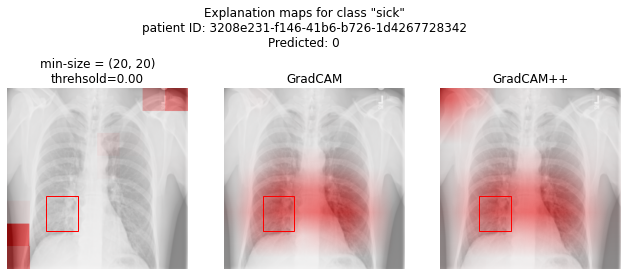

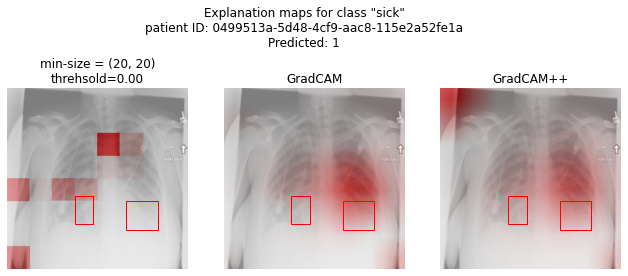

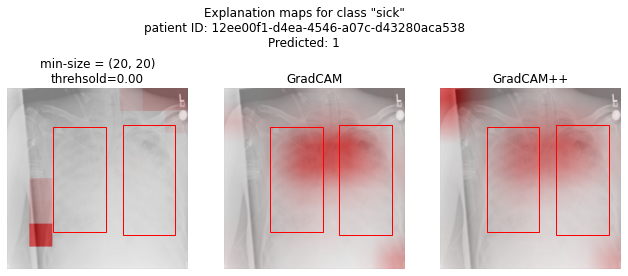

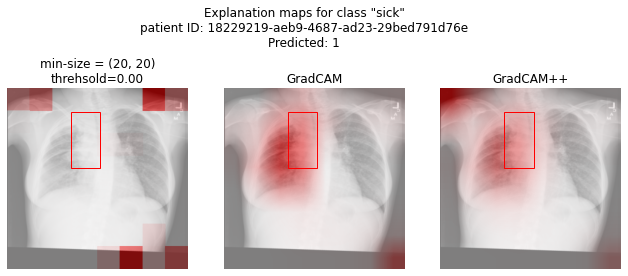

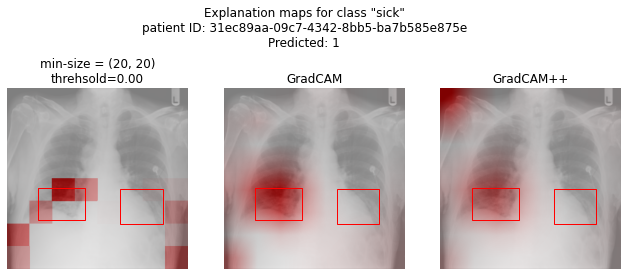

In [21]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import os
import copy
import pandas as pd

# INSTALL GRADCAM, GRADCAM++
!pip install pytorch-gradcam
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

HOME = '/home-2/jtenegg1@jhu.edu/'

IMG_DIR = os.path.join(HOME, 'data/Jacopo/PNA/test/1')
EXPLANATION_DIR = os.path.join(HOME, 'data/Jacopo/PNA_sick_explanations')
patients = os.listdir(EXPLANATION_DIR)
PATIENT_L = len(patients)

preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor()
])

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.299, 0.224, 0.225])

model = models.inception_v3(pretrained=True)
model.aux_logits = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
device = torch.device('cpu')

net_path = os.path.join(HOME, 'data/Jacopo/HShap/Pretrained_models/PNA/InceptionV3')
model.load_state_dict(torch.load(net_path, map_location=device))

# USE THE LAST CONV LAYER TO EXPLAIN (see original paper)
# Keras -> Mixed10
# Pytorch -> Mixed_7c
gradcam = GradCAM(model, model.Mixed_7c)
gradcampp = GradCAMpp(model, model.Mixed_7c)

annotations_path = os.path.join(HOME, 'data/Jacopo/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
df = pd.read_csv(annotations_path)
df_id = df[['patientId']]
df_x = df[['x']]
df_y = df[['y']]
df_width = df[['width']]
df_height = df[['height']]
id = df_id.values.flatten()
x = df_x.values.flatten()
y = df_y.values.flatten()
width = df_width.values.flatten()
height = df.height.values.flatten()

def imshow(ax, pic):
    npimg = np.array(pic)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

def annotate(patient):
    annotations = np.where(id == patient)[0]
    for annotation in annotations:
        box_x = x[annotation]
        box_y = y[annotation]
        box_w = width[annotation]
        box_h = height[annotation]
        rescaled_x = int(box_x / pic_w * INPUT_SIZE)
        rescaled_y = int(box_y / pic_h * INPUT_SIZE)
        rescaled_w = int(box_w / pic_w * INPUT_SIZE)
        rescaled_h = int(box_h / pic_h * INPUT_SIZE)
        box = patches.Rectangle((rescaled_x, rescaled_y), rescaled_w, rescaled_h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(box)

sizes = [20]
thresholds = [0]
SIZE_L = len(sizes)
THRESH_L = len(thresholds)
EXP_L = SIZE_L * THRESH_L
INPUT_SIZE = 299
for patient_id, patient in enumerate(patients[15:20]):
    # OPEN IMAGE
    pic = Image.open(os.path.join(IMG_DIR, '%s.png' % patient)).convert('RGB')
    pic_w, pic_h = pic.size
    # PREPROCESS IMAGE
    input = preprocess(pic)
    model_input = normalize(input)
    model_input = model_input.to(device)
    input_batch = model_input.unsqueeze(0)
    # PREDICT IMAGE CLASS
    output = model(input_batch)
    _, prediction = torch.max(output, 1)
    # INITIALIZE OUTPUT FIGURE
    PATIENT_DIR = os.path.join(EXPLANATION_DIR, patient)
    fig = plt.figure(figsize=(11, 5))
    plt.suptitle('Explanation maps for class "sick"\npatient ID: %s\nPredicted: %d' % (patient, prediction))
    axes = fig.subplots(1, THRESH_L + 2)
    # PLOT HSHAP EXPLANATIONS AND ANNOTATE IMAGES
    for threshold_id, threshold in enumerate(thresholds):
        for size_id, size in enumerate(sizes):
            hexp_saliency = np.load(os.path.join(PATIENT_DIR, '%d_%d.npy' % (threshold_id, size)))
            abs = np.abs(hexp_saliency.flatten())
            max = np.nanpercentile(abs, 99.9)
            ax = axes[threshold_id]
            imshow(ax, input)
            ax.imshow(hexp_saliency, cmap='bwr', alpha=0.5, vmax=max, vmin=-max)
            annotate(patient)
            ax.axis('off')
            ax.set_title('min-size = (%d, %d)\nthrehsold=%.2f' % (size, size, threshold))
    # GRADCAM
    mask, _ = gradcam(input_batch.detach())
    gradcam_saliency = mask.detach().squeeze().numpy()
    gradcam_abs = np.abs(gradcam_saliency.flatten())
    gradcam_max = np.nanpercentile(gradcam_abs, 99.9)
    ax = axes[THRESH_L]
    imshow(ax, input)
    ax.imshow(gradcam_saliency, cmap='bwr', alpha=0.5, vmax=gradcam_max, vmin=-gradcam_max)
    annotate(patient)
    ax.axis('off')
    ax.set_title('GradCAM')
    # GRADCAMpp
    maskpp, _ = gradcampp(input_batch.detach())
    gradcampp_saliency = maskpp.detach().squeeze().numpy()
    gradcampp_abs = np.abs(gradcampp_saliency.flatten())
    gradcampp_max = np.nanpercentile(gradcampp_abs, 99.9)
    ax = axes[THRESH_L + 1]
    imshow(ax, input)
    ax.imshow(gradcampp_saliency, cmap='bwr', alpha=0.5, vmax=gradcampp_max, vmin=-gradcampp_max)
    annotate(patient)
    ax.axis('off')
    ax.set_title('GradCAM++')

plt.show()